In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.12/07


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Endcap_2GeV_add.5.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

def load_pgun_omtf():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Overlap_3GeV_add.5.root'
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  #tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

In [4]:
maxEvents = 400000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,1,3] = 5  # RE1/3
    lut[2,2,2] = 6  # RE2/2
    lut[2,2,3] = 6  # RE2/3
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    lut[0,1,1] = 12 # MB1
    lut[0,2,1] = 13 # MB2
    lut[0,3,1] = 14 # MB3
    lut[0,4,1] = 15 # MB4
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    elif hit.type == kDT:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  def check_emtf_phi(hit):
    if hit.type == kME0:
      return hit.emtf_phi > 0
    elif hit.type == kDT:
      return hit.emtf_phi > 0
    else:
      return True
  #return check_bx(hit) and check_emtf_phi(hit)
  return check_emtf_phi(hit)

In [5]:
# Main analysis

def analysis(verbose=1, omtf=False):
  if omtf:
    tree = load_pgun_omtf()
  else:
    tree = load_pgun()
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 2:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kDT and (hit.station == 1 or hit.station == 2):
        has_ME1 = True
        break
    #if not has_ME1:
    #  continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Skip low pT muons
    if part.pt < 20:
      continue
    
    x_mask_array = np.ones((nlayers,), dtype=np.int32)
    for ihit, hit in enumerate(evt.hits):
      lay = find_emtf_layer(hit)
      if is_emtf_legit_hit(hit):
        x_mask_array[lay] = 0.0
    
    # Output
    out_part.append(part.eta)
    out_hits.append(x_mask_array)
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part), np.asarray(out_hits)

In [6]:
%%time

# Run analysis
out_part, out_hits = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Endcap_2GeV_add.5.root
Processing event: 0
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
Processing event: 100000
Processing event: 110000
Processing event: 120000
Processing event: 130000
Processing event: 140000
Processing event: 150000
Processing event: 160000
Processing event: 170000
Processing event: 180000
Processing event: 190000
Processing event: 200000
Processing event: 210000
Processing event: 220000
Processing event: 230000
Processing event: 240000
Processing event: 250000
Processing event: 260000
Processing event: 270000
Processing event: 280000
Processing event: 290000
Processing event: 300000
Processing event: 310000
Processing event: 320000
Processing event: 330000
Processing event: 340000
Processing event: 350000
Processing event: 360000
Processing event: 

In [7]:
print out_part.shape, out_hits.shape, out_part.dtype, out_hits.dtype

(39219,) (39219, 16) float64 int32


In [8]:
%%time

# Run analysis
out_part_omtf, out_hits_omtf = analysis(omtf=True)

[INFO] Opening file: ../test7/ntuple_SingleMuon_Overlap_3GeV_add.5.root
Processing event: 0
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
Processing event: 100000
Processing event: 110000
Processing event: 120000
Processing event: 130000
Processing event: 140000
Processing event: 150000
Processing event: 160000
Processing event: 170000
Processing event: 180000
Processing event: 190000
Processing event: 200000
Processing event: 210000
Processing event: 220000
Processing event: 230000
Processing event: 240000
Processing event: 250000
Processing event: 260000
Processing event: 270000
Processing event: 280000
Processing event: 290000
Processing event: 300000
Processing event: 310000
Processing event: 320000
Processing event: 330000
Processing event: 340000
Processing event: 350000
Processing event: 360000
Processing event:

In [9]:
print out_part_omtf.shape, out_hits_omtf.shape, out_part_omtf.dtype, out_hits_omtf.dtype

(59476,) (59476, 16) float64 int32


In [10]:
out_part_merged = np.hstack((out_part, out_part_omtf))
out_hits_merged = np.vstack((out_hits, out_hits_omtf))
print out_part_merged.shape, out_hits_merged.shape, out_part_merged.dtype, out_hits_merged.dtype

(98695,) (98695, 16) float64 int32


In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Liberation Sans (u'/usr/share/fonts/liberation/LiberationSans-Regular.ttf') with score of 4.050000
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


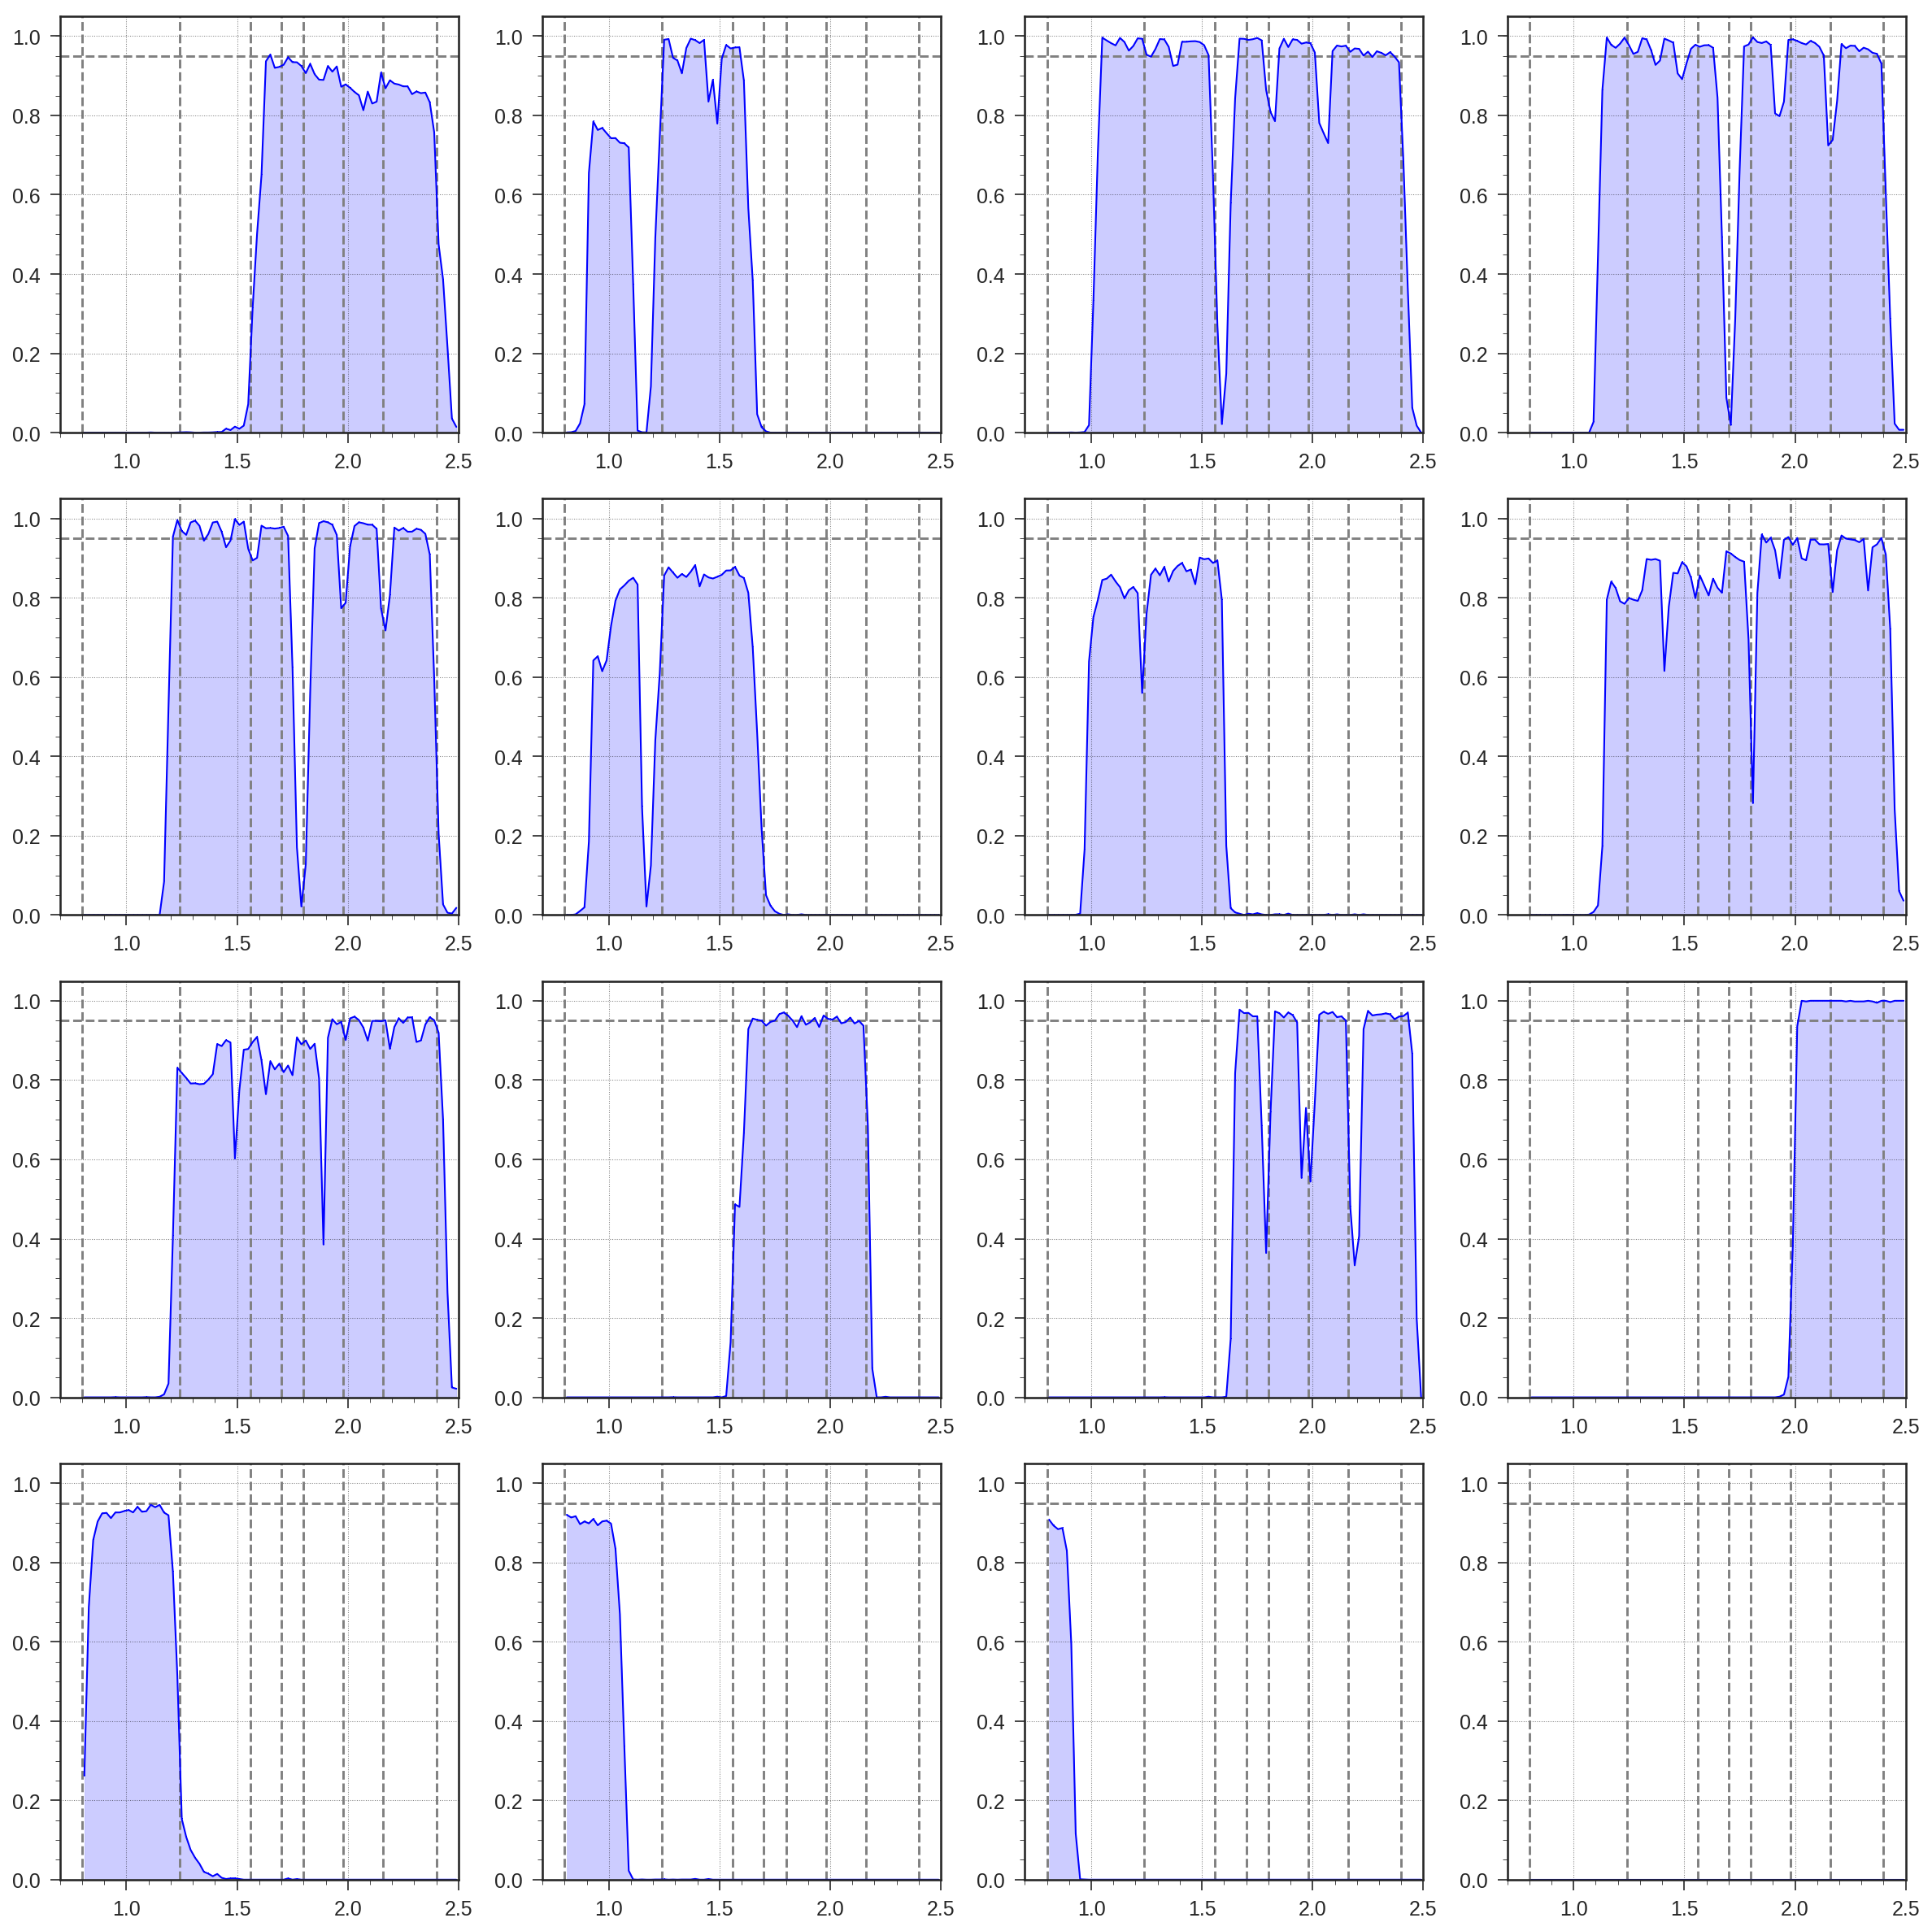

In [12]:
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

#y_eta = out_part.copy()
#x_mask = out_hits.copy().astype(np.bool)

y_eta = out_part_merged.copy()
x_mask = out_hits_merged.copy().astype(np.bool)

for i in xrange(nlayers):
  mask = x_mask[...,i]

  valid = ~mask  # valid hits
  
  xmin, xmax = 0.7, 2.5
  ymin, ymax = 0, 1.05
  nbinsx = 90

  denom_hist, edges = np.histogram(np.abs(y_eta), bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=nbinsx, range=(xmin,xmax))
  eff_hist = np.true_divide(num_hist, denom_hist)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = eff_hist

  ax = axs[i/4,i%4]
  ax.errorbar(xdata, ydata, color='b', marker=',', capsize=0, lw=1)
  ax.fill_between(xdata, 0, ydata, color='b', alpha=0.2)
  for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
    ax.plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [0.95]:  # horizontal lines
    ax.plot([xmin,xmax], [y,y], '--', color='grey')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)

plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


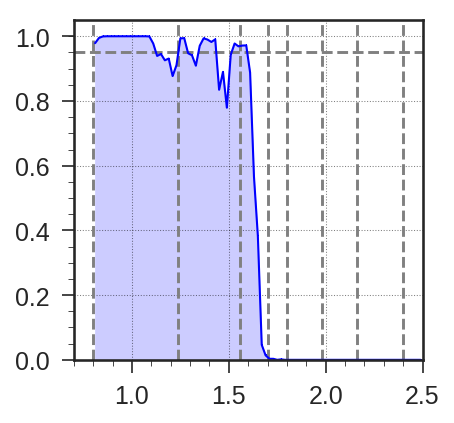

In [13]:
fig, ax = plt.subplots(figsize=(3,3))

y_eta = out_part_merged.copy()
x_mask = out_hits_merged.copy().astype(np.bool)

if True:
  ## Make logical OR of all DT stations
  #valid = ~x_mask[...,12] | ~x_mask[...,13] | ~x_mask[...,14] | ~x_mask[...,15]
  
  ## Make logical OR of all DT+CSC stations
  #valid = ~x_mask[...,12] | ~x_mask[...,13] | ~x_mask[...,14] | ~x_mask[...,15]
  #valid |= ~x_mask[...,1] | ~x_mask[...,2] | ~x_mask[...,3] | ~x_mask[...,4]
  
  # Make logical OR of MB1+MB2+ME1 stations
  valid = ~x_mask[...,12] | ~x_mask[...,13]
  valid |= ~x_mask[...,1]

  xmin, xmax = 0.7, 2.5
  ymin, ymax = 0, 1.05
  nbinsx = 90

  denom_hist, edges = np.histogram(np.abs(y_eta), bins=nbinsx, range=(xmin,xmax))
  num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=nbinsx, range=(xmin,xmax))
  eff_hist = np.true_divide(num_hist, denom_hist)

  xdata = (edges[1:] + edges[:-1])/2
  ydata = eff_hist

  ax.errorbar(xdata, ydata, color='b', marker=',', capsize=0, lw=1)
  ax.fill_between(xdata, 0, ydata, color='b', alpha=0.2)
  for x in [0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4]:  # vertical lines
    ax.plot([x,x], [ymin,ymax], '--', color='grey')
  for y in [0.95]:  # horizontal lines
    ax.plot([xmin,xmax], [y,y], '--', color='grey')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)